# Multiple linear regression

Analysis of the data from J. Durbin and G.S. Watson (1951). "Testing for Serial Correlation in
Least Squares Regression. II," Biometrika, Vol. 38 #1/2 pp. 159-177, obtained from http://users.stat.ufl.edu/~winner/datasets.html.

The dataset contains 5 colums: Year, log spirit consumption per head ($y$), log income per head ($x_1$), log realtive price of spirits ($x_2$), price/income ($x_2/x_1$).

### The model

The model used is the following:

$$ y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \epsilon $$

where the $\beta_i$ are the model parameters, and $\epsilon$ is a Gaussian noise component of the form $\mathcal{N}(0,\sigma_\epsilon)$. Thus, the model has 4 parameters, the 3 $\beta_i$ and the nuisance parameter $\sigma_\epsilon$.

### The prior

We will use uniform "improper" priors on $\beta_i$ and a logarithmic improper prior $\sigma_\epsilon$.

## PyMC3 code

In [1]:
import pymc3 as pm
import pandas as pd
import numpy as np
import arviz as az
import matplotlib.pyplot as plt

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
names = ["year","consumption","income","price"]
spirits_data = pd.read_csv("spirits.dat", header=None, sep="\s+", names=names, usecols=[0,1,2,3])
years = spirits_data.year
spirits_data.drop("year",axis=1,inplace=True)

In [3]:
y, x1, x2 = spirits_data.consumption.values, spirits_data.income.values, spirits_data.price.values
dims = {"y":["year"], "x1":["year"], "x2": ["year"]}
coords = {"year":years}

In [4]:
with pm.Model() as model: # model specifications in PyMC3 are wrapped in a with-statement
    # Define priors
    s_e = pm.HalfCauchy('s_e', beta=10, testval=1.)
    b0 = pm.Uniform('b0', -20, 20)
    b1 = pm.Uniform('b1', -20, 20)
    b2 = pm.Uniform('b2', -20, 20)
    
    # Define likelihood
    likelihood = pm.Normal('y', mu=b0 + b1 * x1 + b2 * x2, 
                        sd=s_e, observed=y)
    
    # Inference!
    trace = pm.sample(progressbar=False) # draw posterior samples using NUTS sampling
    prior = pm.sample_prior_predictive()
    posterior_predictive = pm.sample_posterior_predictive(trace, 500, model)
    
    idata = az.from_pymc3(
        trace=trace,
        prior=prior,
        posterior_predictive=posterior_predictive,
        coords=coords,
        dims=dims,
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b2, b1, b0, s_e]
The acceptance probability does not match the target. It is 0.885458745306593, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8997151528948357, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8867483861667725, but should be close to 0.8. Try to increase the number of tuning steps.
100%|██████████| 500/500 [00:00<00:00, 1865.86it/s]
/home/oriol/venvs/arviz-dev/lib/python3.6/site-packages/arviz/data/io_pymc3.py:56: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  chain_likelihoods.append(np.stack(log_like))


In [5]:
idata

Inference data with groups:
	> posterior
	> sample_stats
	> posterior_predictive
	> prior
	> observed_data

<xarray.Dataset>
Dimensions:  ()
Data variables:
    s_e      float64 1.049e+03
    b0       float64 797.7
    b1       float64 687.3
    b2       float64 824.9


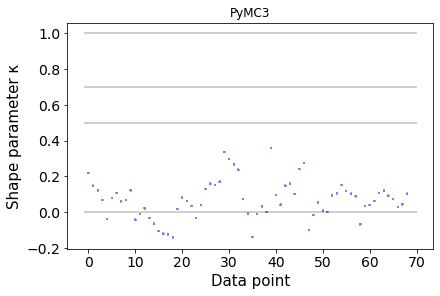

In [6]:
print(az.ess(idata))
loo_df = az.loo(idata,pointwise=True)
ax = az.plot_khat(loo_df.pareto_k)
ax.set_title("PyMC3");

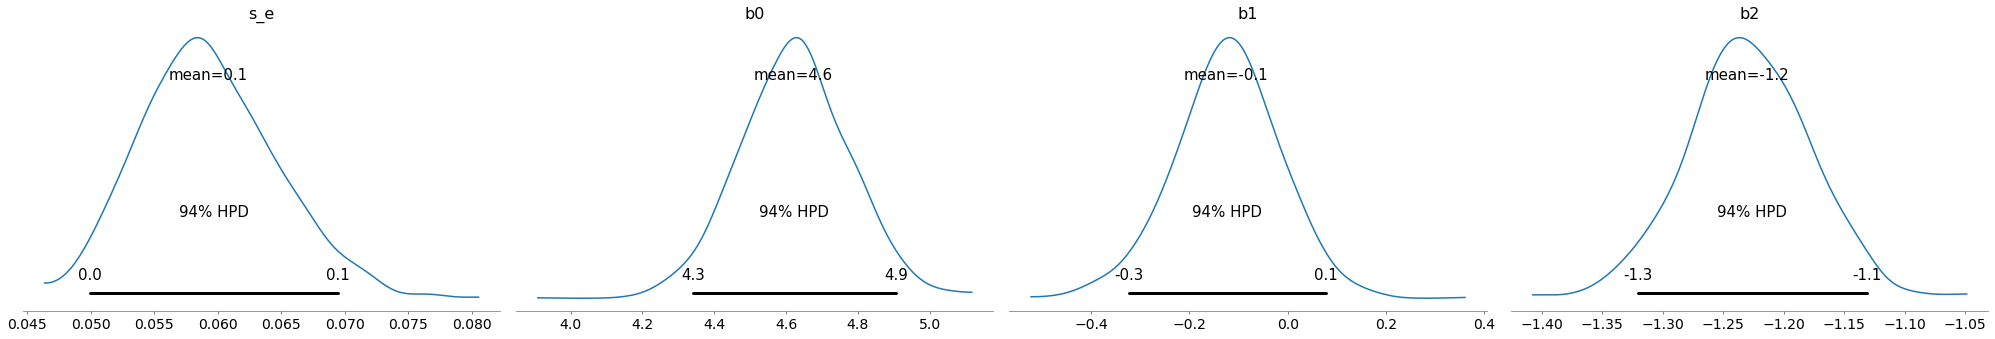

In [7]:
az.plot_posterior(idata);

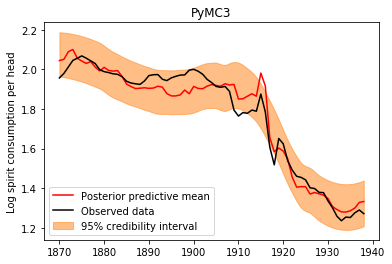

In [8]:
x = idata.observed_data.y.coords["year"].values
y_hats = idata.posterior_predictive.y.values.reshape((-1,69))
az.plot_hpd(x, y_hats,fill_kwargs={"label": "95% credibility interval"});
plt.plot(x, idata.posterior_predictive.y.mean(dim=["draw", "chain"]),color='red',label="Posterior predictive mean")
plt.plot(x, idata.observed_data.y.values,color='k',label="Observed data")
plt.legend(); plt.ylabel("Log spirit consumption per head");
plt.title("PyMC3");

In [9]:
idata.to_netcdf("multiple_LR_pymc.nc")

'multiple_LR_pymc.nc'